In [1]:
pip install pandas scikit-learn matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

# ---------------------------
# STEP 1: CREATE SYNTHETIC DATASET
# ---------------------------
import pandas as pd
import numpy as np

np.random.seed(42)
n = 500  # number of samples

df = pd.DataFrame({
    'Mother_Age': np.random.randint(18, 45, n),
    'Mother_Height': np.random.randint(145, 180, n),  # in cm
    'Mother_Weight': np.random.randint(45, 90, n),    # in kg
    'Gestational_Age': np.random.randint(28, 42, n),  # in weeks
    'Smoking_Status': np.random.choice(['Yes', 'No'], n, p=[0.2, 0.8]),
    'Hypertension': np.random.choice(['Yes', 'No'], n, p=[0.15, 0.85]),
    'Diabetes': np.random.choice(['Yes', 'No'], n, p=[0.1, 0.9]),
    'Number_of_Prenatal_Visits': np.random.randint(1, 12, n)
})

df['BMI'] = df['Mother_Weight'] / ((df['Mother_Height'] / 100) ** 2)
df['Infant_Birth_Weight'] = (
    3000
    + (df['Gestational_Age'] - 37) * 120
    - (df['Smoking_Status'] == 'Yes') * 200
    - (df['Hypertension'] == 'Yes') * 150
    - (df['Diabetes'] == 'Yes') * 100
    + np.random.normal(0, 150, n)
).astype(int)

df.to_csv("synthetic_infant_birth_weight.csv", index=False)

C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
109 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\thris\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666, in _validate_params
    vali


📊 Model Evaluation:
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error: 31054.10
R² Score: 89.59%


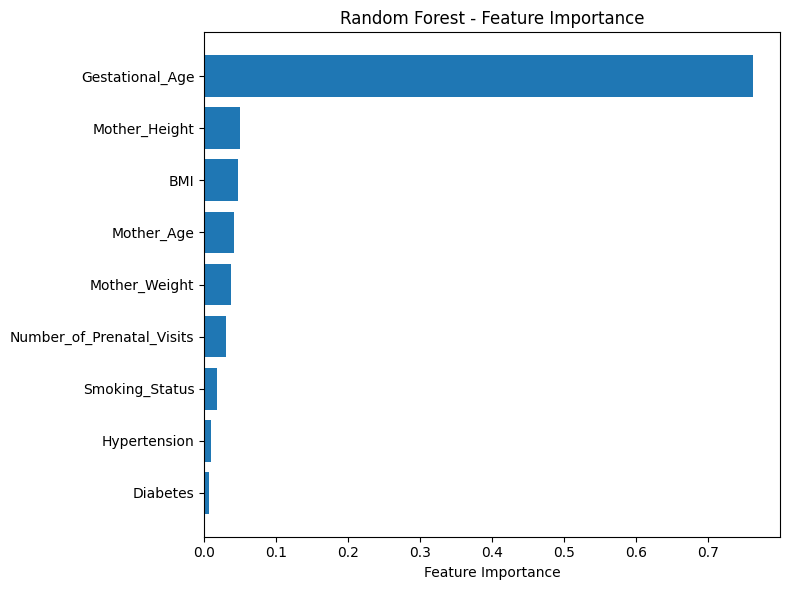

In [3]:
# ---------------------------
# STEP 2: BUILD & EVALUATE MODEL
# ---------------------------
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load synthetic data
df = pd.read_csv("synthetic_infant_birth_weight.csv")

# Encode categorical features
for col in ['Smoking_Status', 'Hypertension', 'Diabetes']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Feature selection
features = [
    'Mother_Age', 'Mother_Height', 'Mother_Weight', 'Gestational_Age',
    'Smoking_Status', 'Hypertension', 'Diabetes',
    'Number_of_Prenatal_Visits', 'BMI'
]
target = 'Infant_Birth_Weight'

X = df[features]
y = df[target]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Random Forest with GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

grid = GridSearchCV(RandomForestRegressor(random_state=42),
                    param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

model = grid.best_estimator_

# Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation:")
print(f"Best Parameters: {grid.best_params_}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2%}")

# Feature importance plot
importances = model.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(8, 6))
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()